In [1]:
##plot
from IPython.display import clear_output, display
import matplotlib.pylab as plt
import seaborn as sns; sns.set()
from matplotlib import colors
from itertools import cycle

#chem
import salty
import gains as genetic
from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']
density_coldic = pd.read_csv('../data/density_coldic.csv')
density_coldic = density_coldic.to_dict(orient='records')[0]
density_categories = pd.read_csv('../data/density_categories.csv')
density_categories = density_categories['category']

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

Using TensorFlow backend.


In [2]:
properties = ['thermal_conductivity', 'cpt', 'density', 'viscosity']
gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, 
                   weights_file='../models/gen3_2mol_1mil_GDB17_mix_pure_5.h5',
                   qspr_outputs=1)

OSError: Unable to open file (Unable to open file: name = '../models/gen3_2mol_1mil_gdb17_mix_pure_5.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

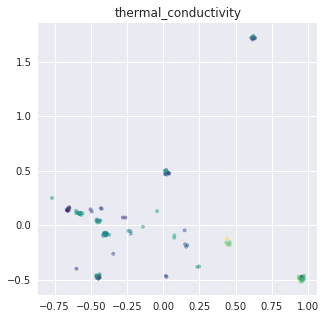

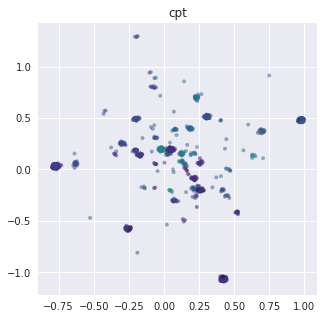

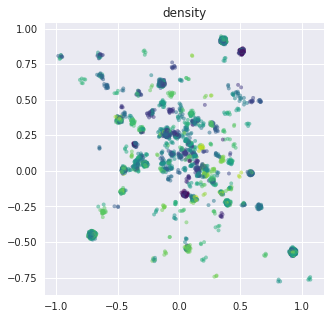

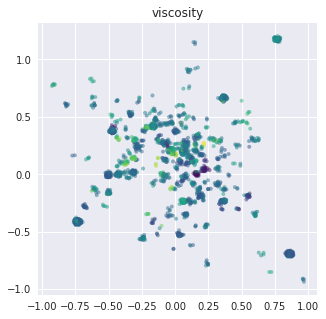

In [18]:
for prop in properties:
    gen3vae.autoencoder.name = prop
    x_train_cat = np.load('../data/{}_x_train_cat.npy'.format(prop))
    x_train_ani = np.load('../data/{}_x_train_ani.npy'.format(prop))
    x_test_cat = np.load('../data/{}_x_test_cat.npy'.format(prop))
    x_test_ani = np.load('../data/{}_x_test_ani.npy'.format(prop))
    y_train = np.load('../data/{}_y_train.npy'.format(prop))
    y_test = np.load('../data/{}_y_test.npy'.format(prop))
    
    z = gen3vae.cation_encoder.predict(np.concatenate([x_train_cat,x_test_cat]))
    z = np.array(z)
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    axs.scatter(pcs[:,0], 
                        pcs[:,1],
                 marker='.',
                    c=np.concatenate([y_train,y_test]), alpha=0.5, cmap='viridis')
    axs.set_title(prop)

In [ ]:
## prepare to load model
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
prop = 'cpt'
x_train_cat = np.load('../data/{}_x_train_cat.npy'.format(prop))

for i in range(50):
    vae = TwoMoleculeVAE()
    vae.create(char_set, char_set, qspr=True, 
               weights_file='../scripts/development/temp_{}_{}.h5'.format(prop,i),
               qspr_outputs=1)

    #test the predictions
    z = vae.cation_encoder.predict(x_train_cat)
    z = np.array(z)
    np.save('../data/latent_arrays/{}_{}.npy'.format(prop, i), z)

In [2]:
## prepare to load model
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
properties = ['thermal_conductivity']

for prop in properties:
    x_train_cat = np.load('../data/{}_x_train_cat.npy'.format(prop))
    for i in range(50):
        vae = TwoMoleculeVAE()
        vae.create(char_set, char_set, qspr=True, 
                   weights_file='../scripts/development/temp_{}_{}.h5'.format(prop,i),
                   qspr_outputs=1)

        #test the predictions
        z = vae.cation_encoder.predict(x_train_cat)
        z = np.array(z)
        np.save('../data/latent_arrays/{}_{}.npy'.format(prop, i), z)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


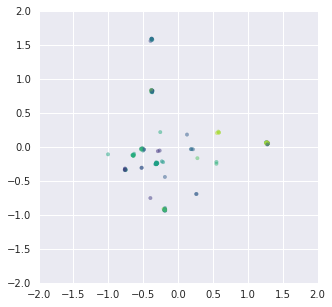

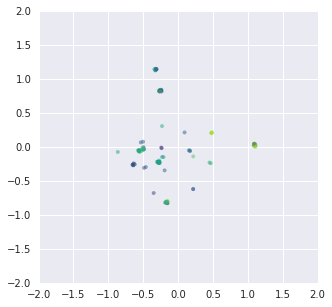

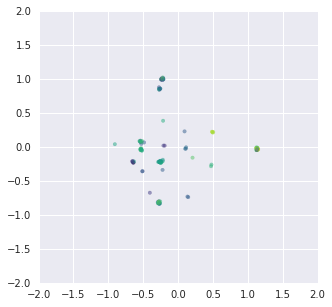

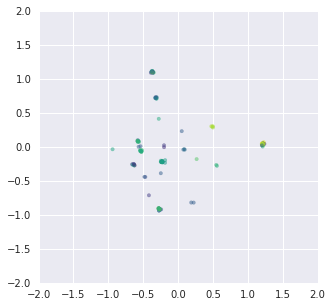

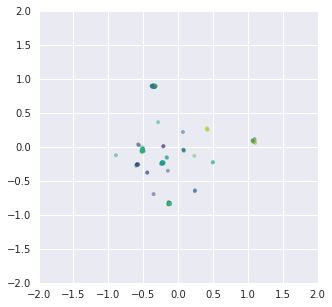

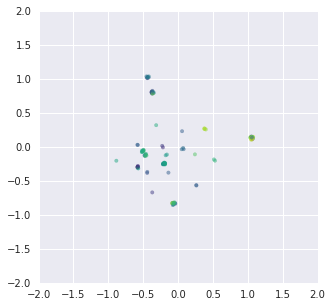

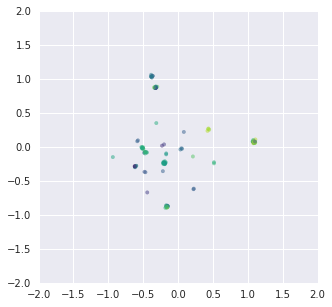

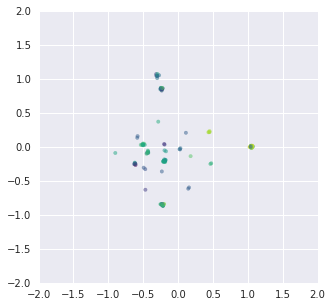

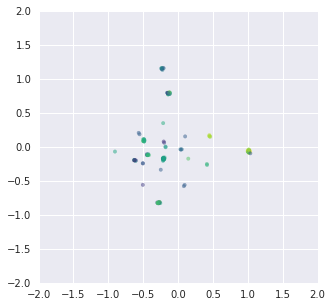

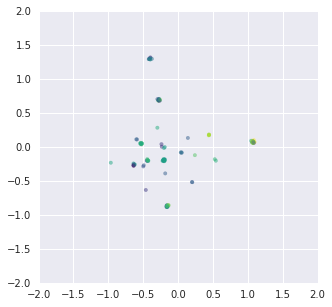

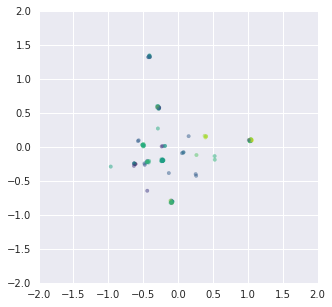

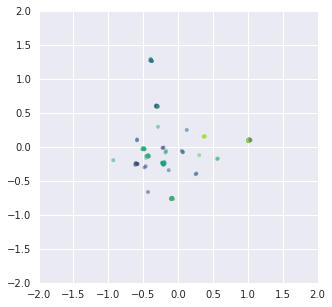

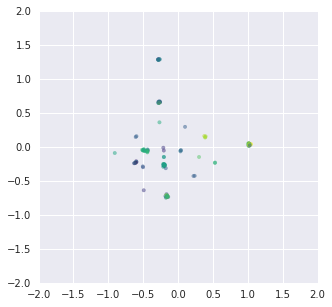

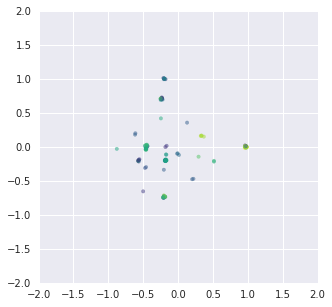

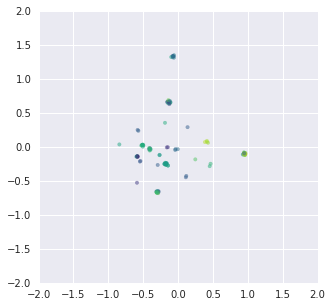

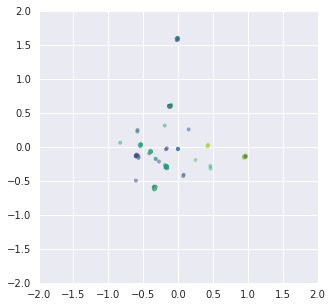

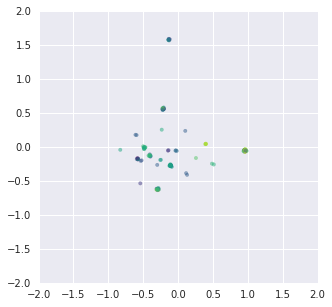

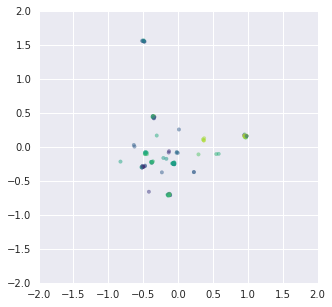

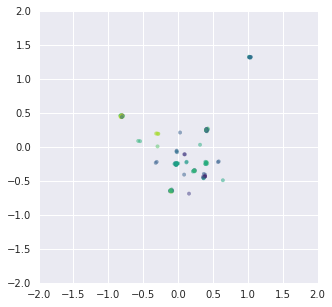

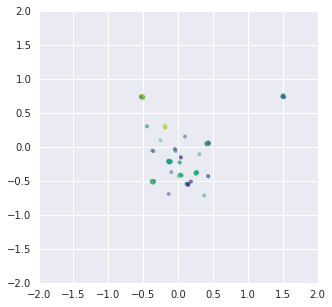

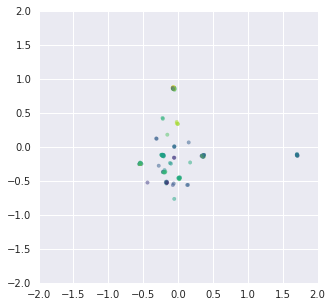

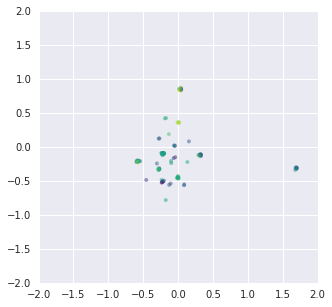

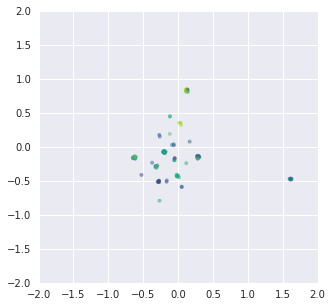

In [19]:
prop= 'thermal_conductivity'

for epoch in range(23):
    z = np.load('../data/latent_arrays/{}_{}.npy'.format(prop, epoch))
    y_train = np.load('../data/{}_y_train.npy'.format(prop))
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    fig, axs = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
    axs.scatter(pcs[:,0], 
                        pcs[:,1],
                 marker='.',
                    c=(y_train), alpha=0.5, cmap='viridis')
    axs.set_ylim(-2,2)
    axs.set_xlim(-2,2)

In [ ]:
prop= 'viscosity'

for epoch in range(50):
    z = np.load('../data/latent_arrays/{}_{}.npy'.format(prop, epoch))
    y_train = np.load('../data/{}_y_train.npy'.format(prop))
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    fig, axs = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
    axs.scatter(pcs[:,0], 
                        pcs[:,1],
                 marker='.',
                    c=(y_train), alpha=0.5, cmap='viridis')
    axs.set_ylim(-2,2)
    axs.set_xlim(-2,2)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


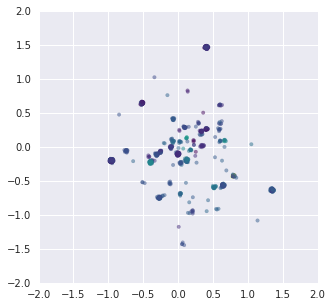

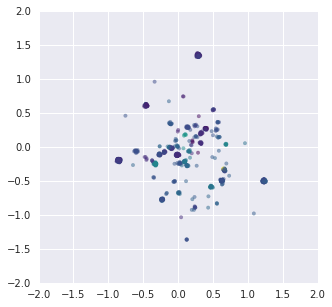

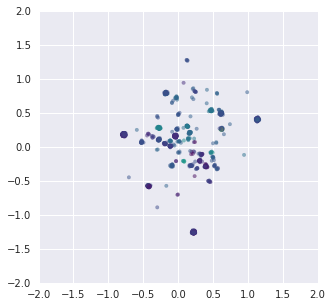

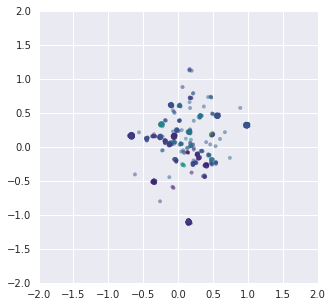

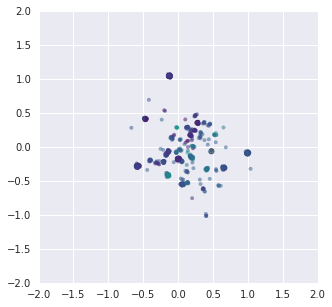

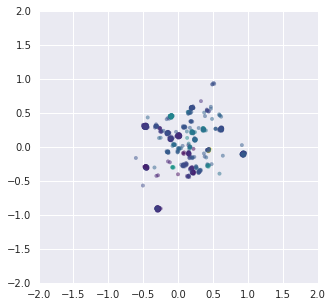

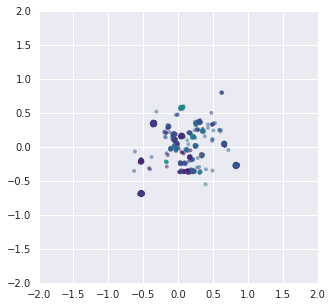

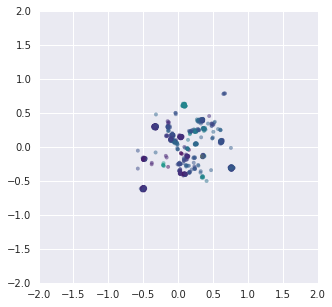

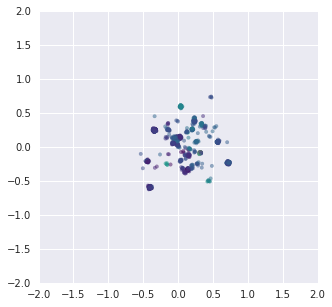

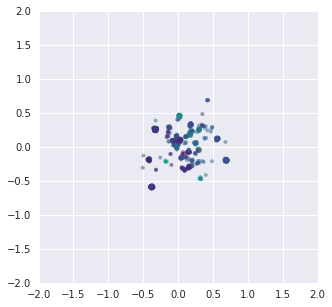

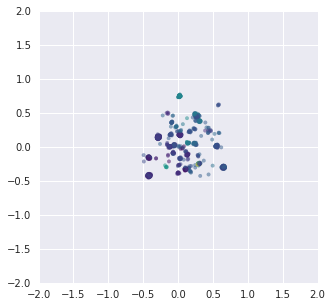

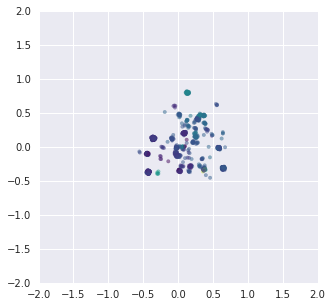

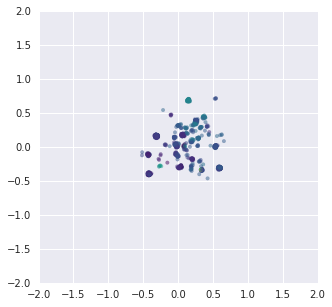

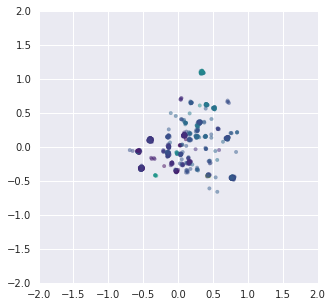

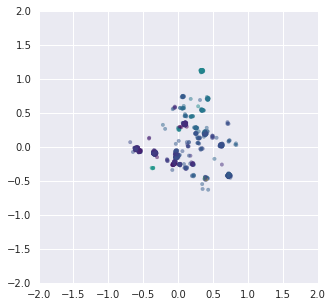

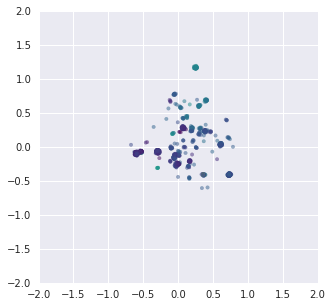

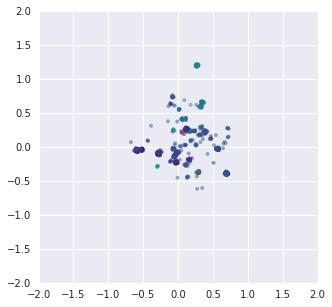

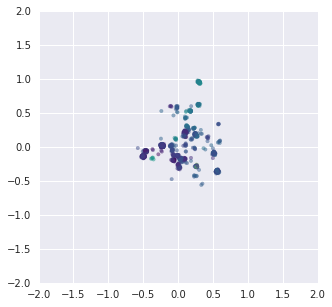

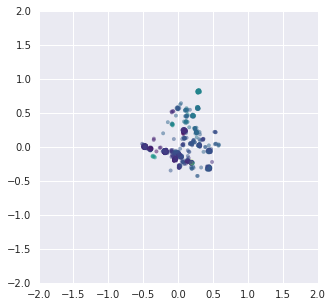

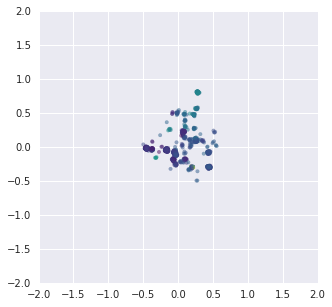

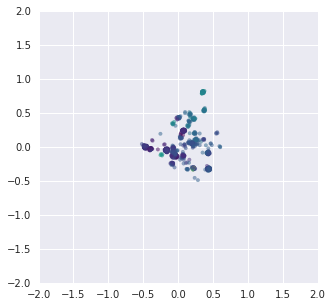

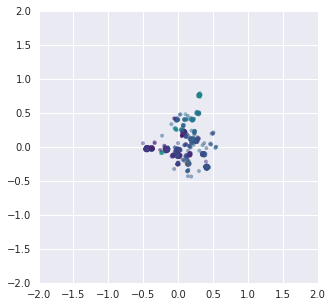

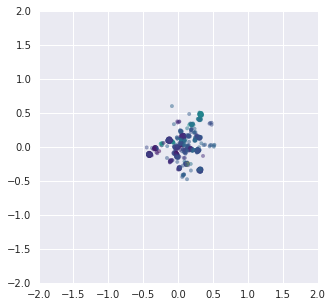

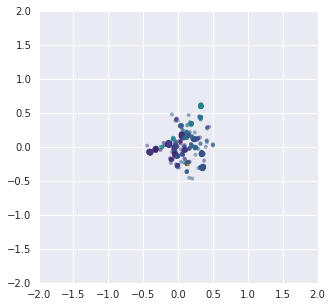

In [9]:
prop= 'cpt'

for epoch in range(24):
    z = np.load('../data/latent_arrays/{}_{}.npy'.format(prop, epoch))
    y_train = np.load('../data/{}_y_train.npy'.format(prop))
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    fig, axs = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
    axs.scatter(pcs[:,0], 
                        pcs[:,1],
                 marker='.',
                    c=(y_train), alpha=0.5, cmap='viridis')
    axs.set_ylim(-2,2)
    axs.set_xlim(-2,2)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


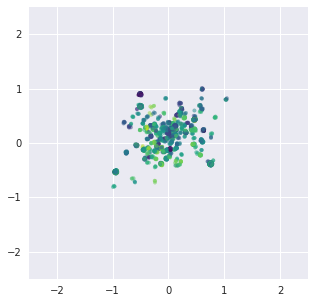

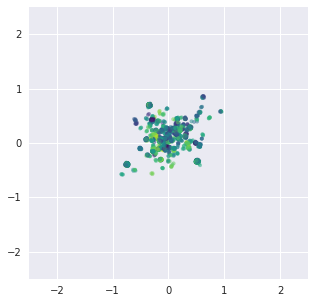

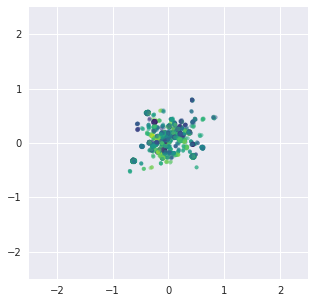

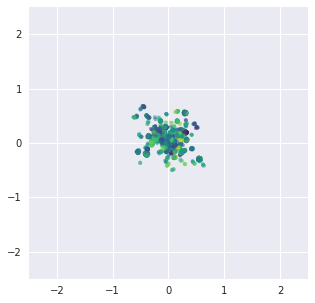

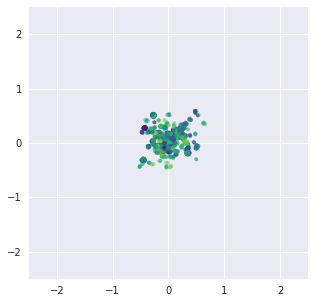

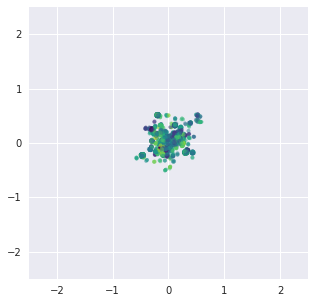

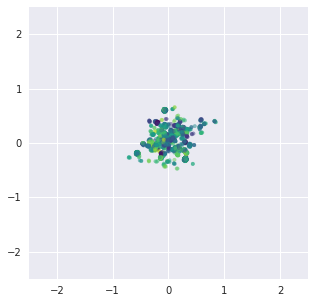

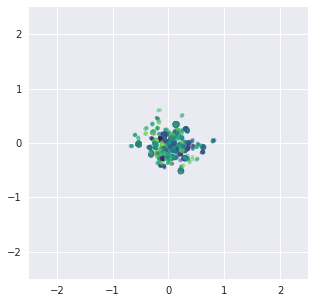

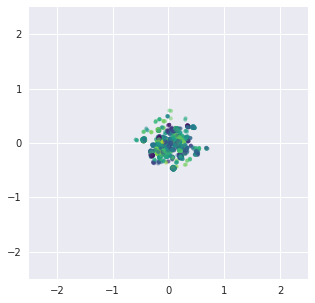

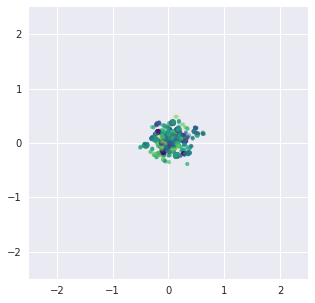

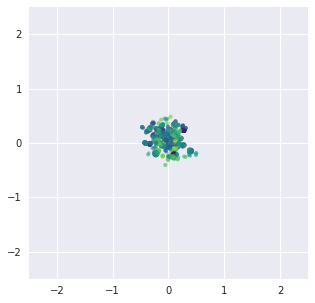

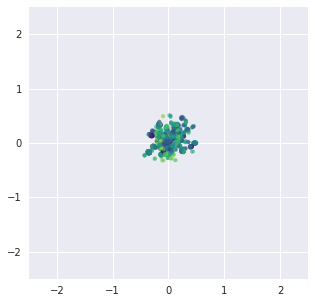

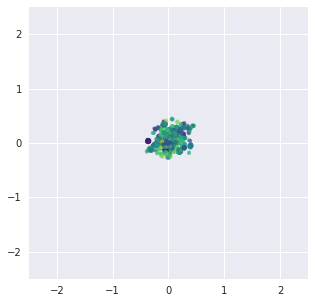

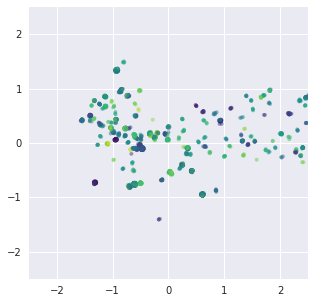

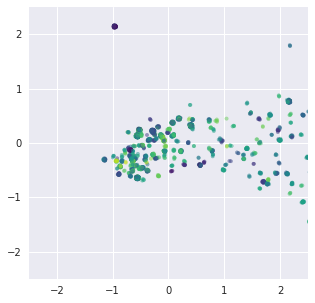

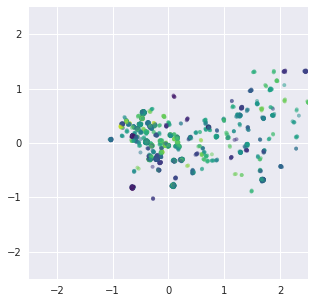

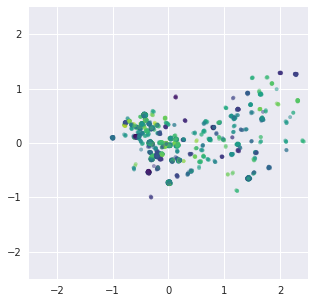

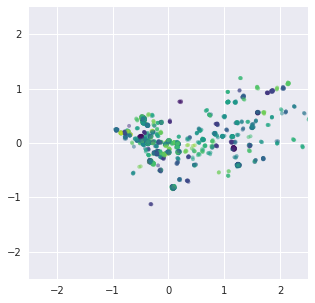

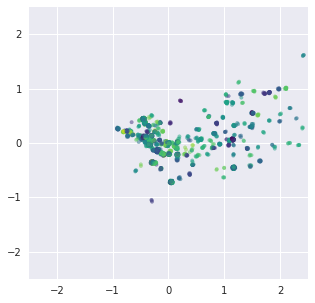

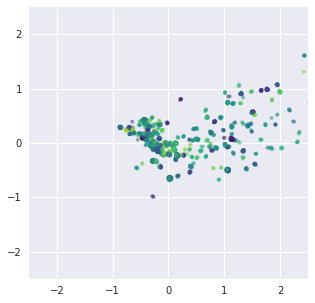

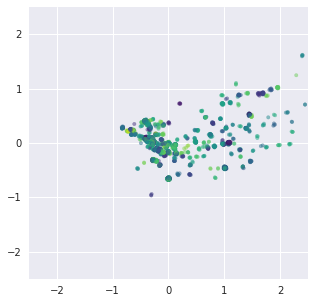

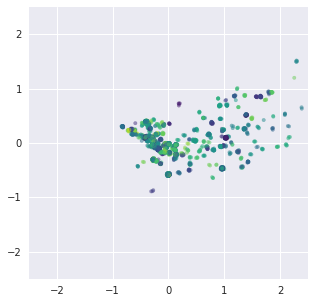

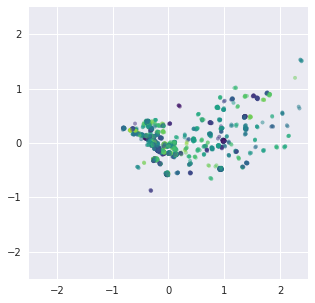

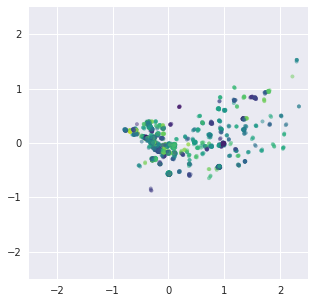

In [10]:
prop= 'density'

for epoch in range(24):
    z = np.load('../data/latent_arrays/{}_{}.npy'.format(prop, epoch))
    y_train = np.load('../data/{}_y_train.npy'.format(prop))
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    fig, axs = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
    axs.scatter(pcs[:,0], 
                        pcs[:,1],
                 marker='.',
                    c=(y_train), alpha=0.5, cmap='viridis')
    axs.set_ylim(-2.5,2.5)
    axs.set_xlim(-2.5,2.5)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


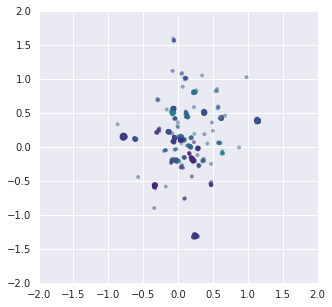

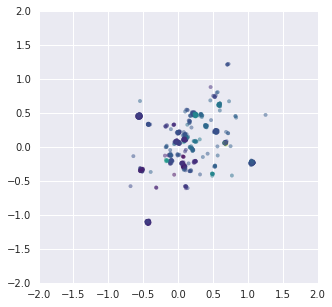

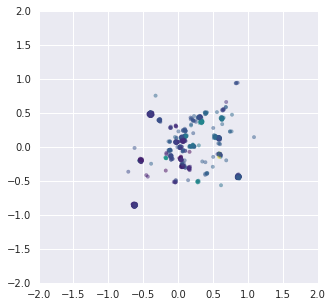

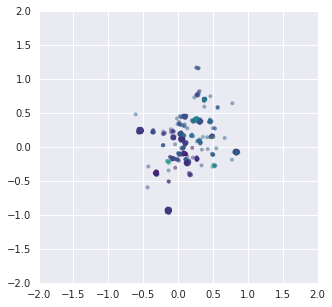

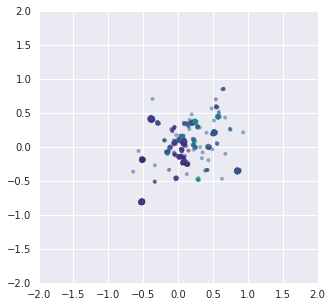

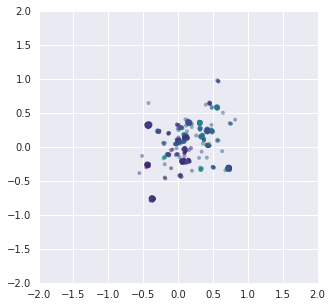

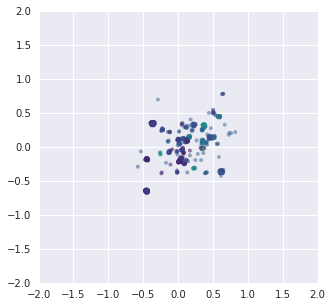

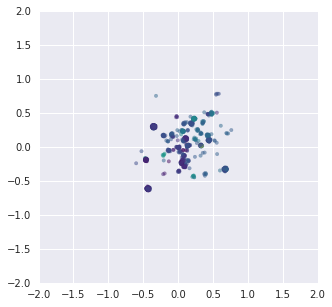

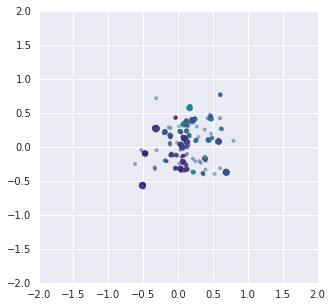

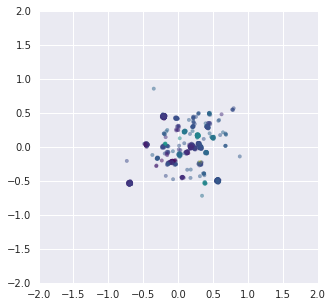

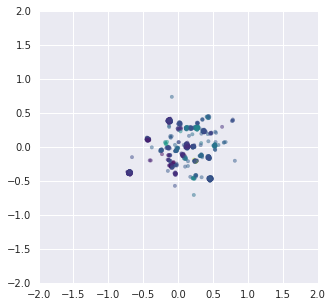

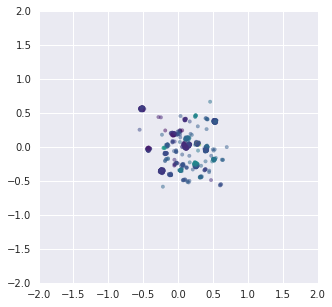

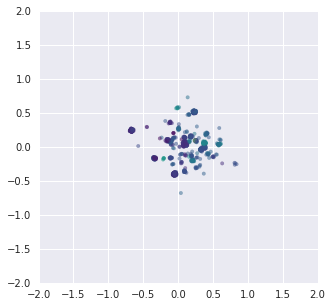

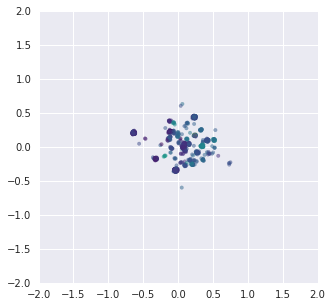

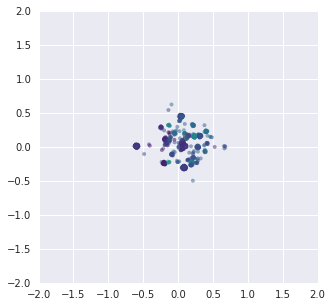

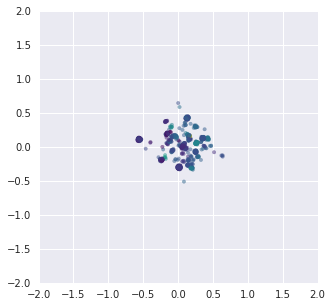

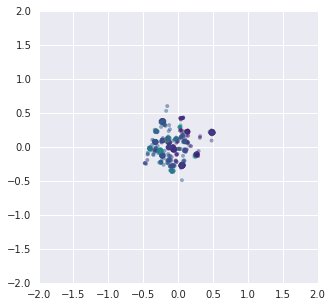

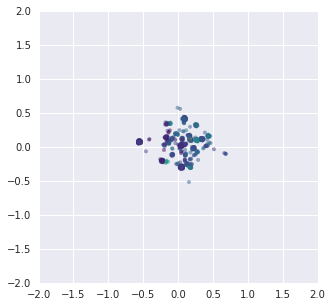

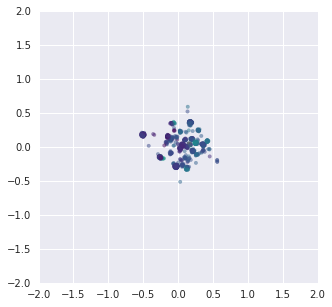

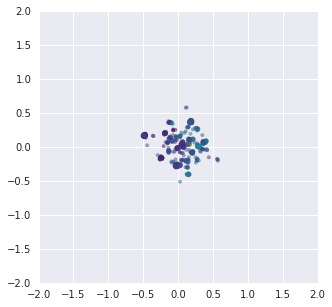

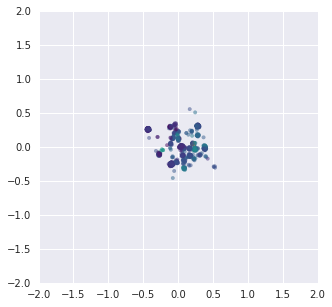

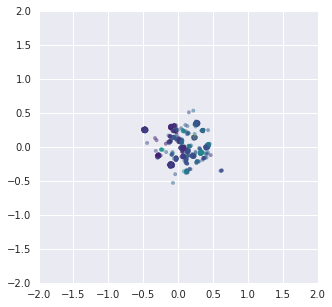

In [7]:
prop= 'cpt'

for epoch in range(22):
    z = np.load('../data/latent_arrays/{}_{}.npy'.format(prop, epoch))
    y_train = np.load('../data/{}_y_train.npy'.format(prop))
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    fig, axs = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
    axs.scatter(pcs[:,0], 
                        pcs[:,1],
                 marker='.',
                    c=(y_train), alpha=0.5, cmap='viridis')
    axs.set_ylim(-2,2)
    axs.set_xlim(-2,2)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


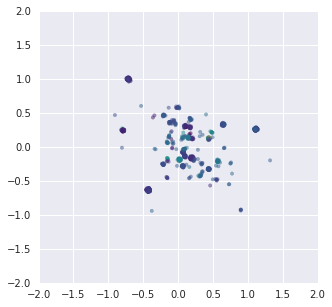

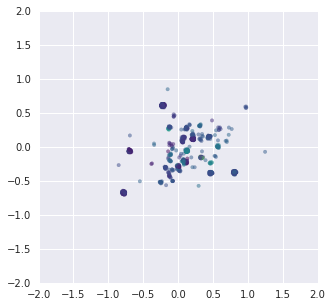

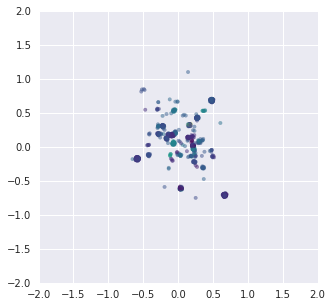

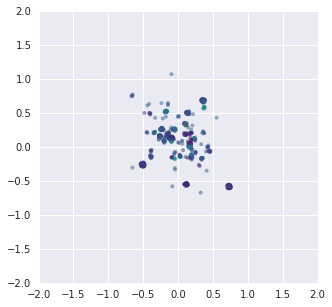

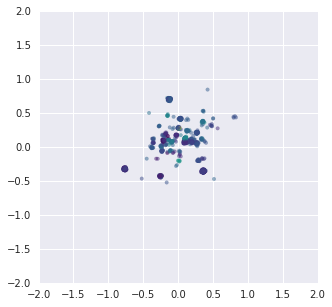

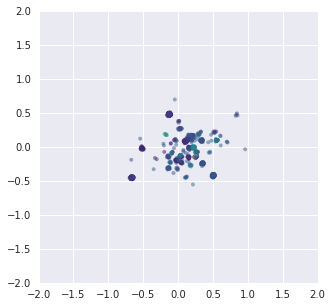

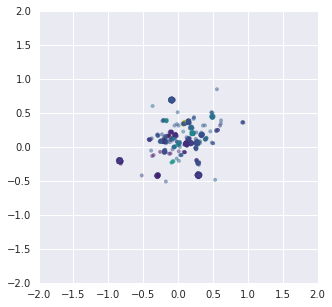

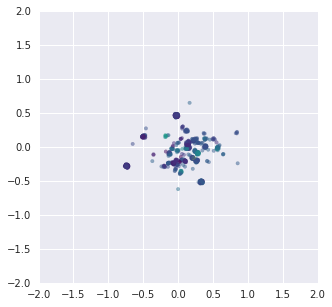

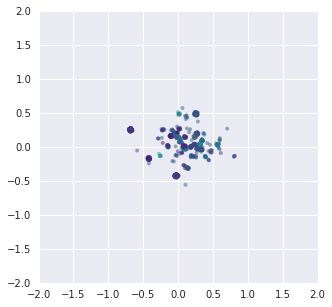

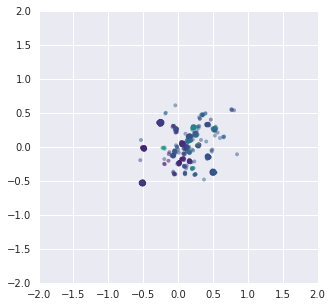

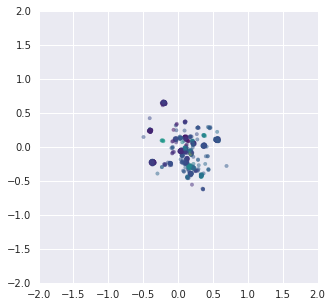

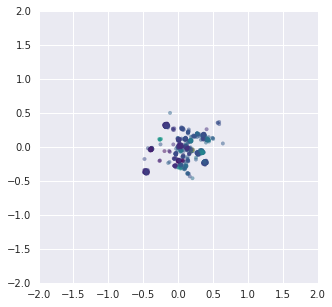

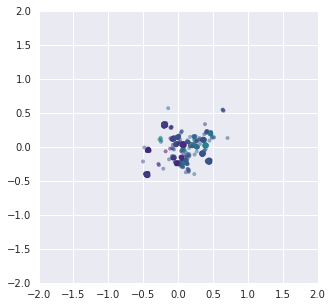

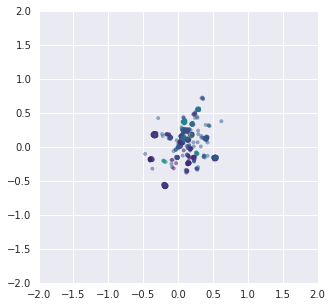

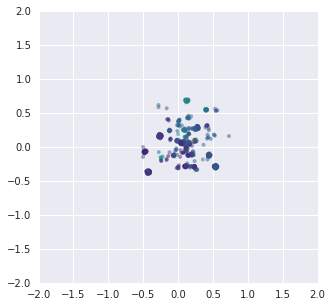

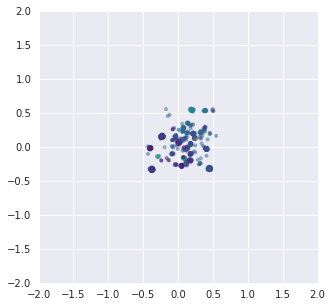

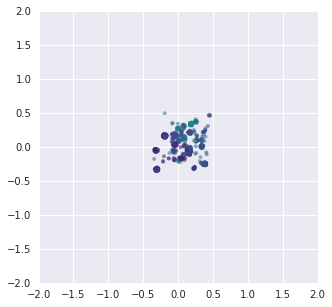

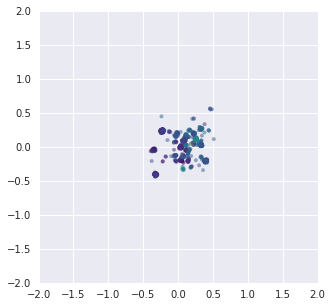

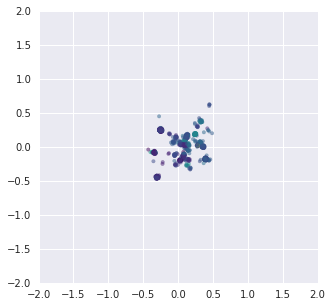

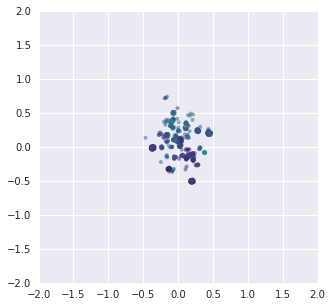

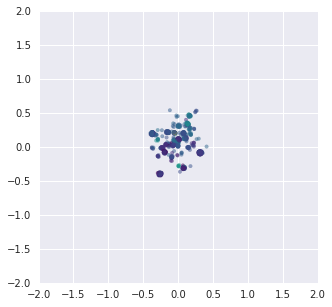

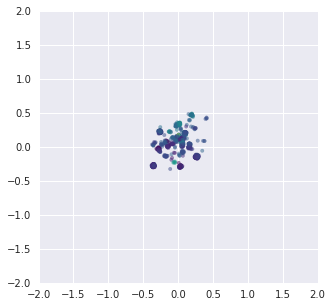

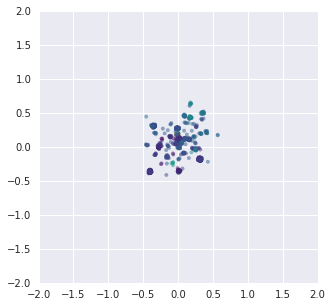

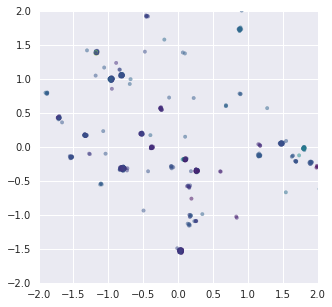

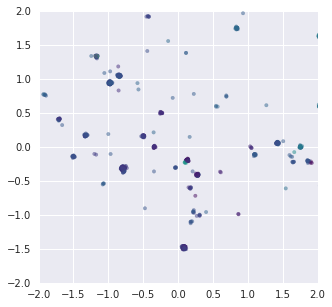

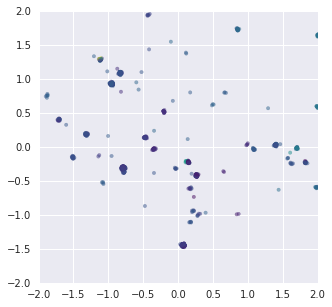

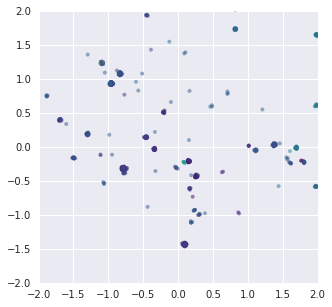

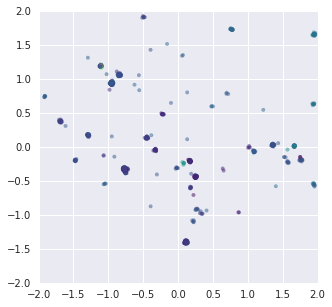

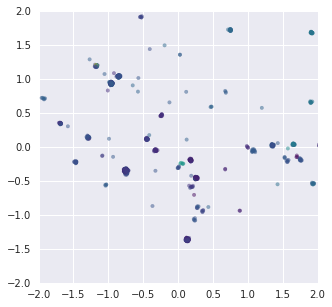

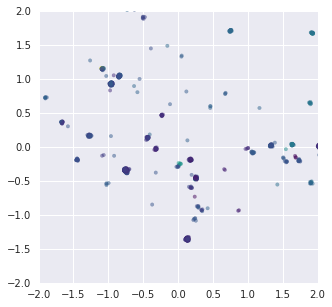

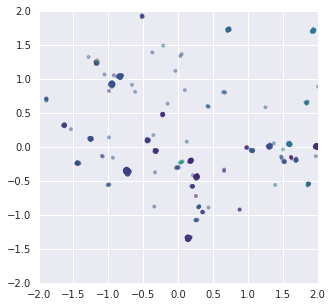

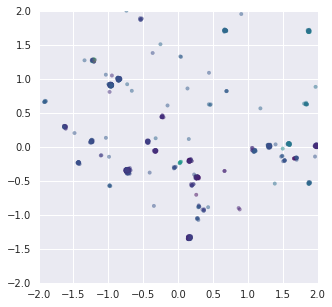

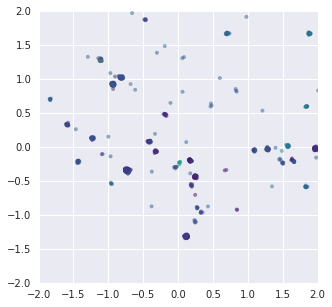

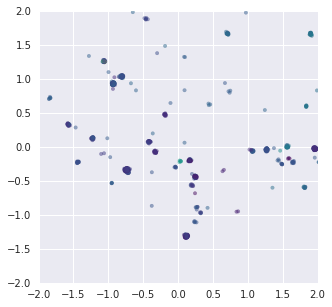

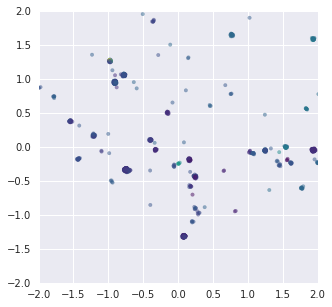

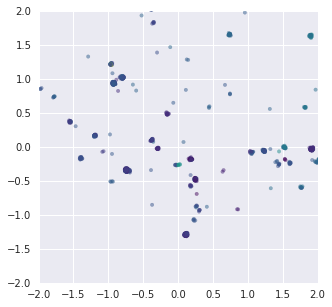

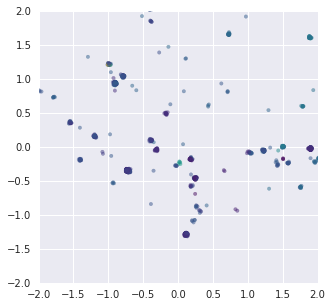

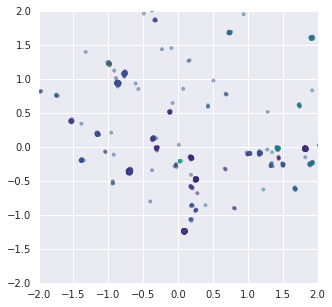

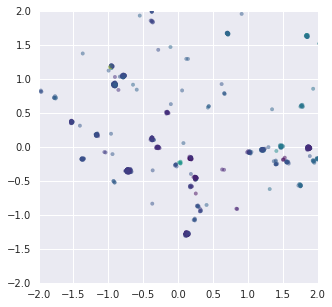

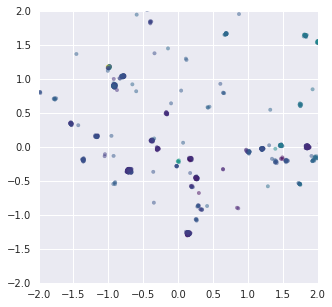

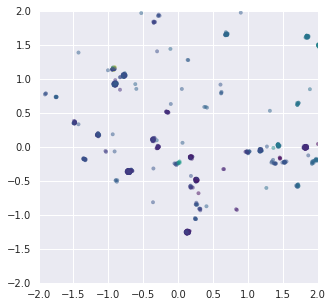

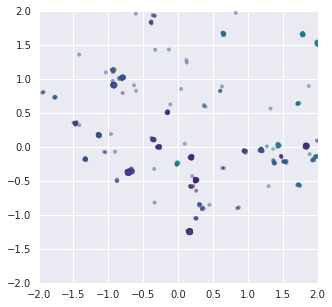

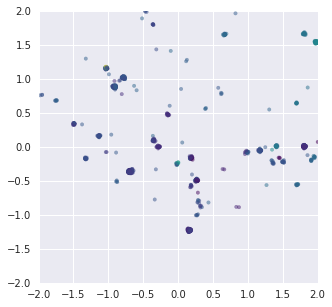

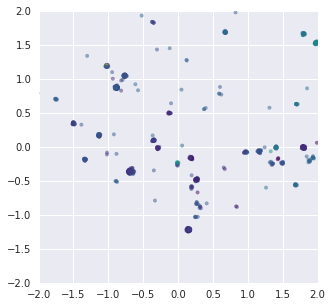

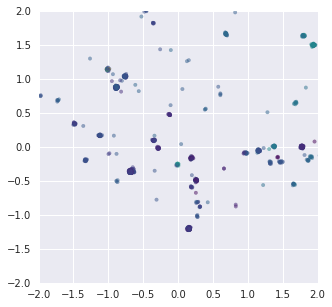

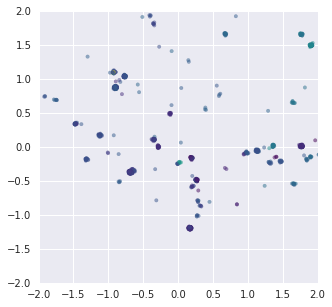

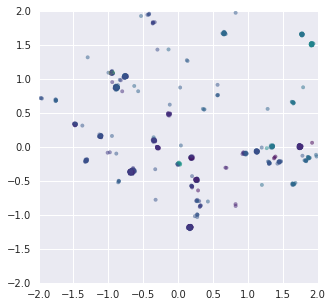

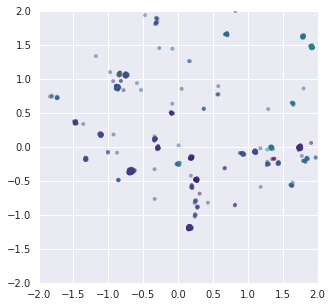

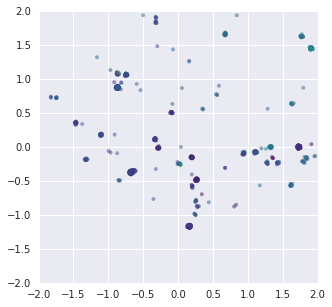

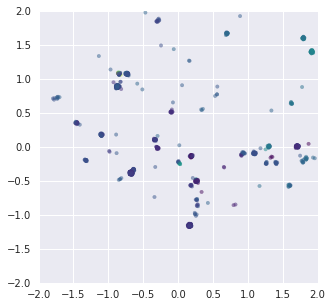

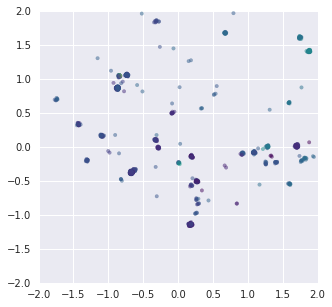

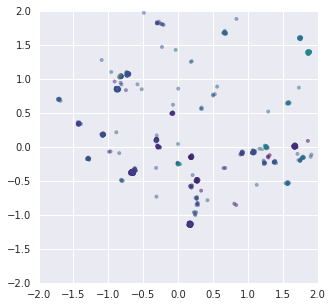

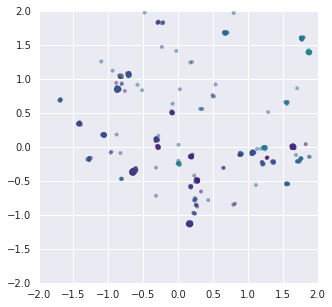

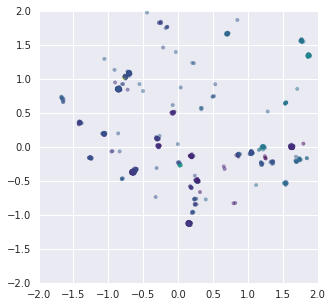

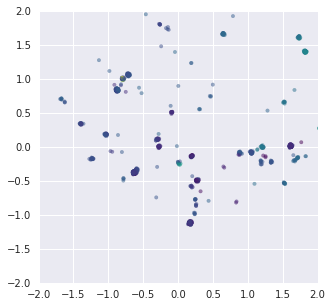

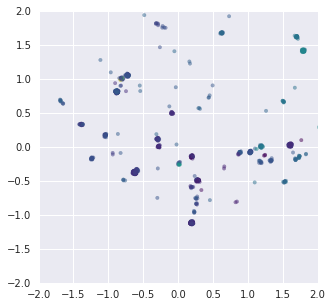

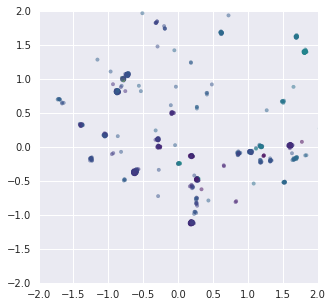

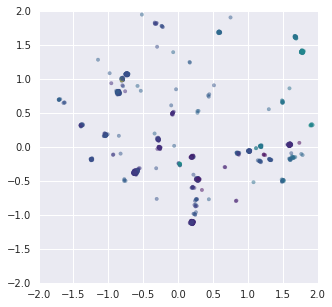

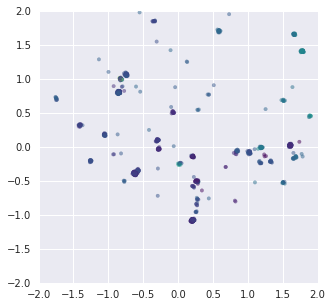

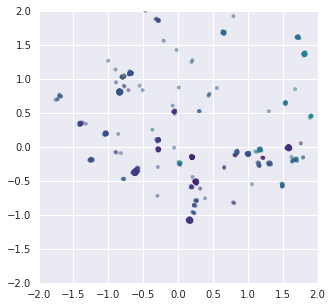

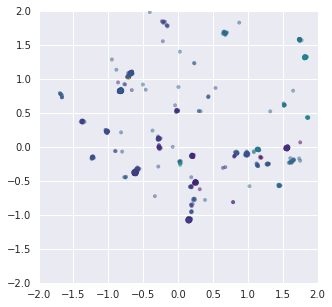

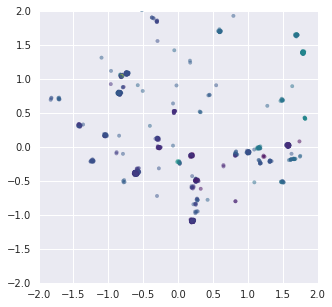

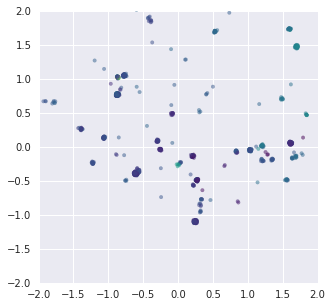

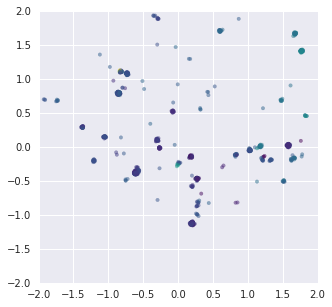

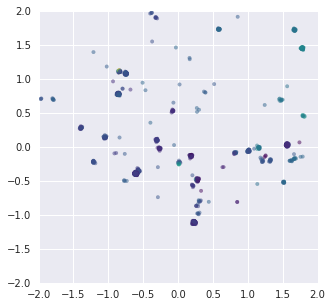

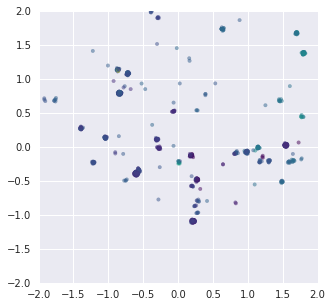

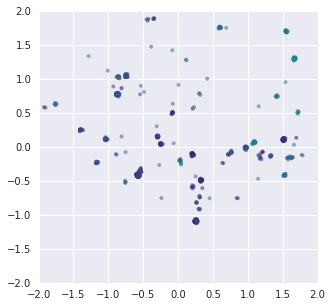

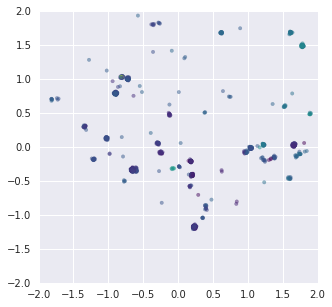

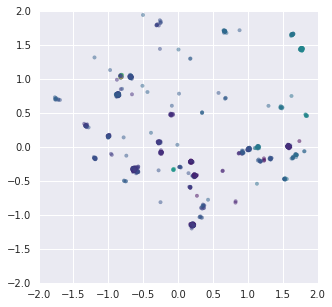

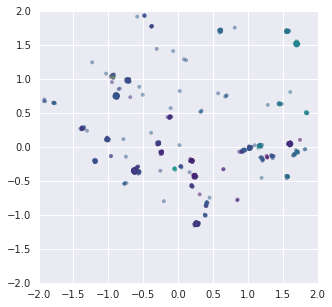

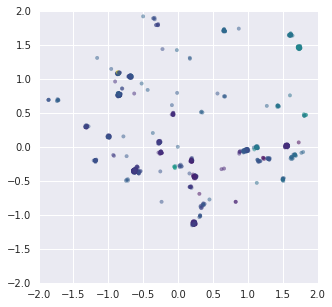

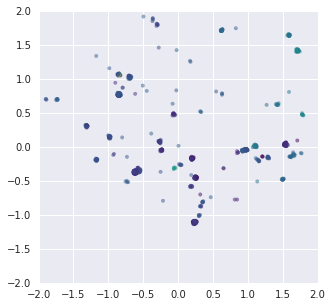

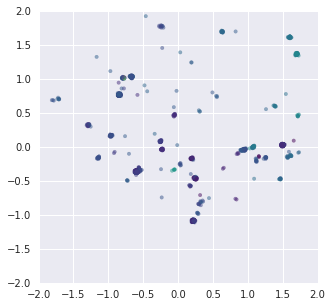

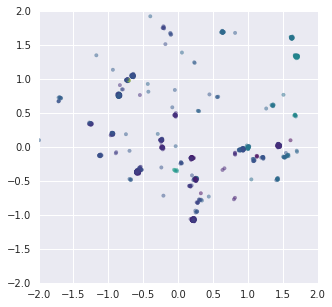

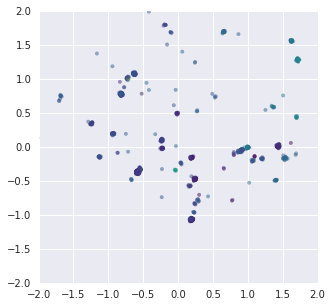

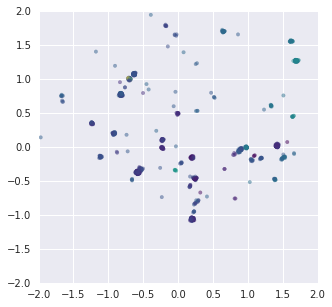

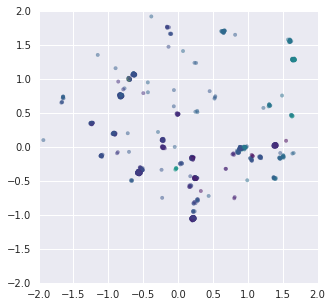

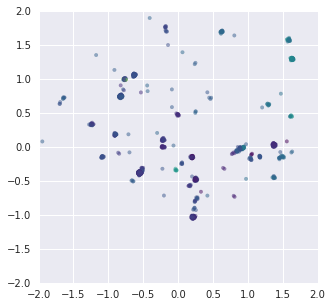

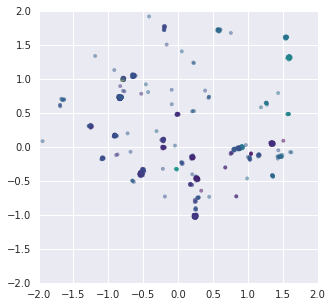

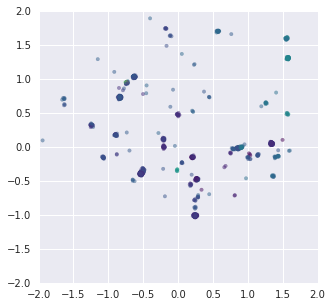

In [8]:
prop= 'cpt'

for epoch in range(80):
    z = np.load('cation_embeddings_latent_test_{}_{}.npy'.format(prop, epoch))
    y_train = np.load('../data/{}_y_train.npy'.format(prop))
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    fig, axs = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
    axs.scatter(pcs[:,0], 
                        pcs[:,1],
                 marker='.',
                    c=(y_train), alpha=0.5, cmap='viridis')
    axs.set_ylim(-2,2)
    axs.set_xlim(-2,2)